In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from VIME import utils
from VIME.estimator import VIMESelfEstimator, VIMESemiEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

/root/software/miniconda3/envs/tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/software/miniconda3/envs/tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/software/miniconda3/envs/tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/root/software/miniconda3/envs/tf1/lib/python3

### **Titanic**

In [2]:
# load mnist
(x_train, y_train), (x_valid, y_valid), cat_cols = utils.load_titanic_dataset()

In [54]:
# define params
params = {
    "latent_sz": 4,
    "num_dims": 7,
    "alpha": 0.5,
    "learning_rate": 1e-3,
    "dropout": 0.25,
    "p_m": 0.25,
    "cat_cols": cat_cols
}
# define train input_fn
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X_unlabel": x_train},
    y=y_train,
    batch_size=512,
    num_epochs=None,
    shuffle=True
)
# define eval input_fn
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X_unlabel": x_valid},
    num_epochs=1,
    shuffle=False
)
estimator = VIMESelfEstimator(model_dir="./model",params=params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4467a9b7f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [55]:
for i in range(3):
    # TRAIN
    train_res = estimator.train(input_fn=train_input_fn, steps=100)
    # EVAL
    eval_res = estimator.evaluate(input_fn=eval_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-1500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1500 into ./model/model.ckpt.
INFO:tensorflow:loss = 1.0425606, step = 1501
INFO:tensorflow:Saving checkpoints for 1600 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.83340836.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-09-02T01:53:22Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-1600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2023-09-02-01:53:23
INFO:tensorflow:Saving dict for global step 1600: global_step = 1600, loss = 0.7375331

In [56]:
# get encoded latent representation
x_latent_train = utils.get_latent_representation(x_train, estimator)
x_latent_valid = utils.get_latent_representation(x_valid, estimator)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-1800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-1800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [57]:
# build classifier with latent feature
model = RandomForestClassifier(n_jobs=-1, min_samples_leaf=16)
model.fit(x_latent_train, y_train)
train_acc = accuracy_score(y_train, model.predict(x_latent_train))
valid_acc = accuracy_score(y_valid, model.predict(x_latent_valid))
print("train acc using latent feature: %.4f"%(train_acc))
print("valid acc using latent feature: %.4f"%(valid_acc))

train acc using latent feature: 0.8164
valid acc using latent feature: 0.7540


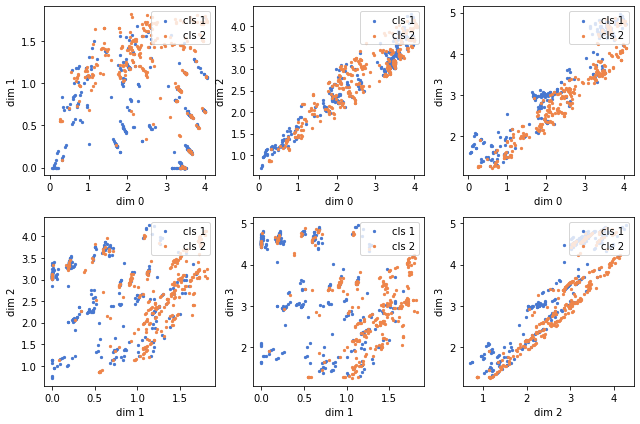

In [58]:
utils.plot_latent_representation(x_latent_train, y_train)

### **MNIST**

In [12]:
# load mnist
(x_train, y_train), (x_valid, y_valid), cat_cols = utils.load_mnist_dataset(num_cat=392)

In [13]:
# define params
params = {
    "latent_sz": 6,
    "num_dims": 28*28,
    "alpha": 0.5,
    "learning_rate": 1e-3,
    "dropout": 0.4,
    "p_m": 0.4,
    "cat_cols": cat_cols
}
# define train input_fn
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X_unlabel": x_train},
    y=y_train,
    batch_size=512,
    num_epochs=None,
    shuffle=True
)
# define eval input_fn
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X_unlabel": x_valid},
    num_epochs=1,
    shuffle=False
)
estimator = VIMESelfEstimator(model_dir="./model_mnist",params=params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './model_mnist', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0699d11ac8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [14]:
for i in range(5):
    # TRAIN
    train_res = estimator.train(input_fn=train_input_fn, steps=50)
    # EVAL
    eval_res = estimator.evaluate(input_fn=eval_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./model_mnist/model.ckpt.
INFO:tensorflow:loss = 1.5554595, step = 1
INFO:tensorflow:Saving checkpoints for 50 into ./model_mnist/model.ckpt.
INFO:tensorflow:Coordinator stopped with threads still running: Thread-66
INFO:tensorflow:Loss for final step: 0.85585856.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-09-01T06:39:10Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model_mnist/model.ckpt-50
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2023-09-01-06:39:44
INFO:tensorflow:Saving dict for global step 50: global_step = 50, loss

In [15]:
# get encoded latent representation
x_latent_train = utils.get_latent_representation(x_train, estimator)
x_latent_valid = utils.get_latent_representation(x_valid, estimator)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model_mnist/model.ckpt-250
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model_mnist/model.ckpt-250
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [16]:
# build classifier with latent feature
model = RandomForestClassifier(n_jobs=-1, min_samples_leaf=20)
model.fit(x_latent_train, y_train)

RandomForestClassifier(min_samples_leaf=20, n_jobs=-1)

In [17]:
train_acc = accuracy_score(y_train, model.predict(x_latent_train))
valid_acc = accuracy_score(y_valid, model.predict(x_latent_valid))
print("train acc using latent feature: %.4f"%(train_acc))
print("valid acc using latent feature: %.4f"%(valid_acc))

train acc using latent feature: 0.5500
valid acc using latent feature: 0.4645


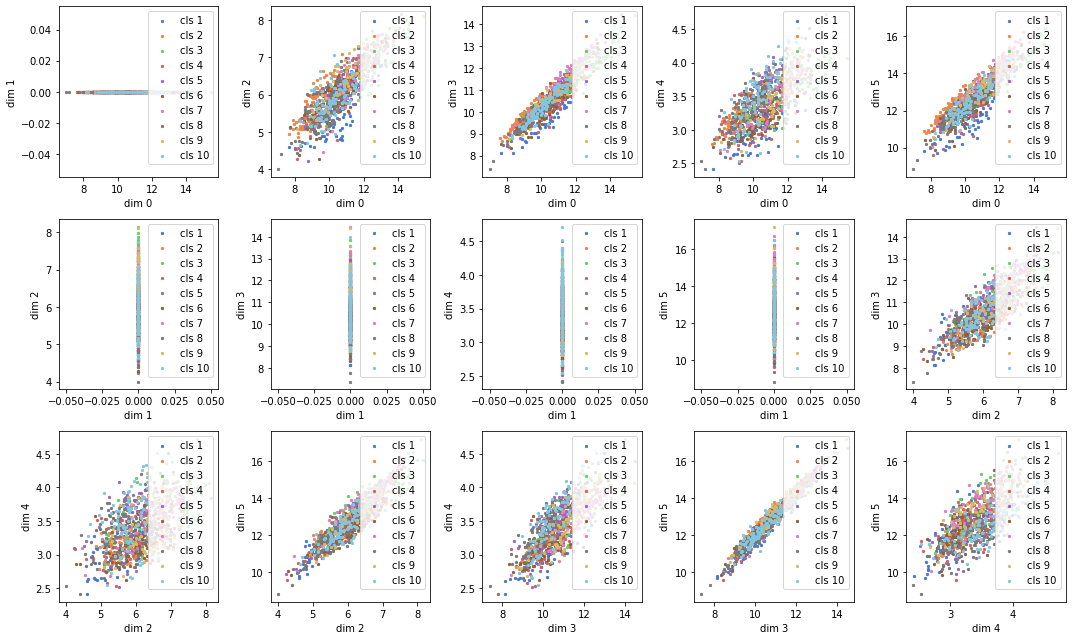

In [18]:
n_plot = 1000
utils.plot_latent_representation(x_latent_train[:n_plot], y_train[:n_plot])